# 11_CNN_CIFAR-10_CUDA

In [90]:
# Pytorch Library
import torch
import torch.nn.init
import torchvision
from torch.autograd import Variable
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

########################################################################
# The output of torchvision datasets are PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1]

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=10)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=10)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


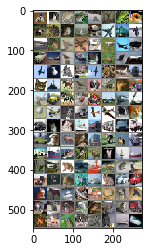

horse   dog  frog  frog


In [4]:
# Let us show some of the training images, for fun.

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


In [8]:
########################################################################
# 2. Define a Convolution Neural Network
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # take 3-channel images (instead of 1-channel images as it was defined).
        self.conv1 = nn.Conv2d(3, 24, 5)
        self.b1 = nn.BatchNorm2d(24)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(24, 64, 5)
        self.b2 = nn.BatchNorm2d(64)
        
        self.fc1 = nn.Linear(64 * 5 * 5, 240)
        self.fc2 = nn.Linear(240, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.b1(self.conv1(x))))
        x = self.pool(F.relu(self.b2(self.conv2(x))))
        x = x.view(-1, 64 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
net.load_state_dict(torch.load('CNN.pkl'))  # Load the Trained Model
net.cuda()

Net (
  (conv1): Conv2d(3, 24, kernel_size=(5, 5), stride=(1, 1))
  (b1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True)
  (pool): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d(24, 64, kernel_size=(5, 5), stride=(1, 1))
  (b2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (fc1): Linear (1600 -> 240)
  (fc2): Linear (240 -> 84)
  (fc3): Linear (84 -> 10)
)

In [9]:
########################################################################
# 3. Define a Loss function and optimizer
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Let's use a Classification Cross-Entropy loss and SGD with momentum

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [21]:
########################################################################
# 4. Train the network
# ^^^^^^^^^^^^^^^^^^^^
#
# This is when things start to get interesting.
# We simply have to loop over our data iterator, and feed the inputs to the
# network and optimize

for epoch in range(250):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs).cuda(), Variable(labels).cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if i % 128 == 127:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 128))
            running_loss = 0.0
            
    correct = 0
    total = 0
    for data in testloader:
        images, labels = data
        outputs = net(Variable(images).cuda())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))

print('Finished Training')

torch.save(net.state_dict(), 'CNN.pkl')  # Save the Model

[1,   128] loss: 0.007
[1,   256] loss: 0.010
[1,   384] loss: 0.012
Accuracy of the network on the 10000 test images: 66 %
[2,   128] loss: 0.007
[2,   256] loss: 0.005
[2,   384] loss: 0.013
Accuracy of the network on the 10000 test images: 66 %
[3,   128] loss: 0.008
[3,   256] loss: 0.008
[3,   384] loss: 0.008
Accuracy of the network on the 10000 test images: 66 %
[4,   128] loss: 0.007
[4,   256] loss: 0.004
[4,   384] loss: 0.005
Accuracy of the network on the 10000 test images: 66 %
[5,   128] loss: 0.004
[5,   256] loss: 0.004
[5,   384] loss: 0.012
Accuracy of the network on the 10000 test images: 65 %
[6,   128] loss: 0.011
[6,   256] loss: 0.015
[6,   384] loss: 0.013
Accuracy of the network on the 10000 test images: 66 %
[7,   128] loss: 0.008
[7,   256] loss: 0.011
[7,   384] loss: 0.008
Accuracy of the network on the 10000 test images: 66 %
[8,   128] loss: 0.009
[8,   256] loss: 0.006
[8,   384] loss: 0.004
Accuracy of the network on the 10000 test images: 66 %
[9,   12

Process Process-656:
Process Process-655:
Process Process-658:
Process Process-654:
Process Process-651:
Process Process-659:
Process Process-657:


KeyboardInterrupt: 

Traceback (most recent call last):
Traceback (most recent call last):
Process Process-652:
  File "/home/isjeon/anaconda3/envs/lab_conda/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Process Process-660:
  File "/home/isjeon/anaconda3/envs/lab_conda/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
Process Process-653:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/isjeon/anaconda3/envs/lab_conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/isjeon/anaconda3/envs/lab_conda/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/isjeon/anaconda3/envs/lab_conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File

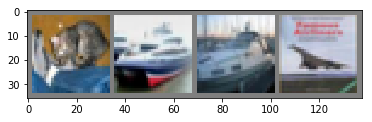

GroundTruth:    cat  ship  ship plane


Process Process-50:
Process Process-49:
Process Process-43:
Process Process-48:
Process Process-42:
Process Process-47:
Process Process-44:
Process Process-41:
Process Process-46:
Process Process-45:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/isjeon/anaconda3/envs/lab_conda/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/isjeon/anaconda3/envs/lab_conda/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/isjeon/anaconda3/envs/lab_conda/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/isjeon/anaconda3/envs/lab_conda/lib/python3.6/multip

In [18]:

########################################################################
# 5. Test the network on the test data
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
#
# We have trained the network for 2 passes over the training dataset.
# But we need to check if the network has learnt anything at all.
#
# We will check this by predicting the class label that the neural network
# outputs, and checking it against the ground-truth. If the prediction is
# correct, we add the sample to the list of correct predictions.
#
# Okay, first step. Let us display an image from the test set to get familiar.

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))


In [19]:

########################################################################
# Okay, now let us see what the neural network thinks these examples above are:

outputs = net(Variable(images).cuda())

########################################################################
# The outputs are energies for the 10 classes.
# Higher the energy for a class, the more the network
# thinks that the image is of the particular class.
# So, let's get the index of the highest energy:
_, predicted = torch.max(outputs.data.cpu(), 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4) ))


Predicted:    cat   car   cat  bird


In [20]:

########################################################################
# The results seem pretty good.
#
# Let us look at how the network performs on the whole dataset.

correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = net(Variable(images).cuda())
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted.cpu() == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the 10000 test images: 66 %


In [9]:

########################################################################
# That looks waaay better than chance, which is 10% accuracy (randomly picking
# a class out of 10 classes).
# Seems like the network learnt something.
#
# Hmmm, what are the classes that performed well, and the classes that did
# not perform well:

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    outputs = net(Variable(images.cuda()))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted.cpu() == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))


Accuracy of plane : 65 %
Accuracy of   car : 75 %
Accuracy of  bird : 49 %
Accuracy of   cat : 43 %
Accuracy of  deer : 54 %
Accuracy of   dog : 48 %
Accuracy of  frog : 71 %
Accuracy of horse : 66 %
Accuracy of  ship : 75 %
Accuracy of truck : 71 %
